# Bike sharing Availability Forecast: The Seoul Case Study

*A siginificat component of contemporary urban transportation systems in bike sharing. It gives people a flexible, afforable and environmentally friendlyway to travel short distances.*

*Customers frequently strglle to locate a bie when they need one, predominantly during busy commute times or in particular weather conditions. Due to this very discreoacy between customer demand and bike availability, bike share company operators tend to lose money and customers as they are dissatisfied.*


# Business Question
Taking into account the rationale for, such as times of day, season, weather and holidays how many biked will be rented in a given hour? 

By answering this question, the company would be able to find out: 
- Anticipate demand patterns more accurately 
- Allocate as well as redistribute bikes more efficiently 
- Reduce operating costs while enhancing customer satisfaction 

In [22]:
#importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# For the machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# To try conbinations on the trainung data set.
from sklearn.model_selection import GridSearchCV


## Load the data
- Dataset: *Seoul Bike Sharing Demand Prediction* from Kaggle
- File: link -->  https://www.kaggle.com/datasets/saurabhshahane/seoul-bike-sharing-demand-prediction
 

In [4]:
df = pd.read_csv("/Users/enoshniju/Downloads/SeoulBikeData.csv", encoding="ISO-8859-1")
print("Shape:", df.shape)
df.head()


Shape: (8760, 14)


,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


To understand the structure and quality of the dataset. Which allows us to give an overview of the datset and helps indetify any data qualtiy issues that need to be adressed before moving on forward.

In [5]:
# Missing values
print("Missing values:")
print(df.isna().sum())

# Quick stats
print("Summary statistics:")
print(df.describe())

# Unique values in categorical columns
print("Unique values in Seasons:", df['Seasons'].unique())
print("Unique values in Holiday:", df['Holiday'].unique())
print("Unique values in Functioning Day:", df['Functioning Day'].unique())


Missing values:
Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64
Summary statistics:
       Rented Bike Count         Hour  Temperature(°C)  Humidity(%)  \
count        8760.000000  8760.000000      8760.000000  8760.000000   
mean          704.602055    11.500000        12.882922    58.226256   
std           644.997468     6.922582        11.944825    20.362413   
min             0.000000     0.000000       -17.800000     0.000000   
25%           191.000000     5.750000         3.500000    42.000000   
50%           504.500000    11.500000        13.700000    57.000000   
75%          1065.25

# EDA 

*Average rentals by hour of the day*

From running the code youcan see: 

- Very low rentals in the early morning 2–5am, possibly because of the reason being the city seems to go to sleep.

- Morning peak around 8am perfectly around the time the city wakes up

- Evening peak around 6–7pm showcasing the highest 

- Drop-off specifically at night.

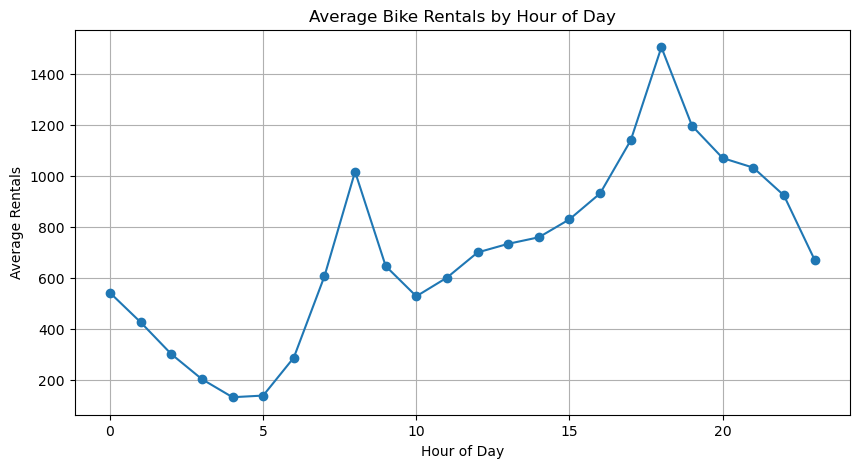

In [6]:

# Group by Hour and take mean rentals
avg_by_hour = df.groupby("Hour")["Rented Bike Count"].mean()

plt.figure(figsize=(10,5))
plt.plot(avg_by_hour.index, avg_by_hour.values, marker="o")
plt.title("Average Bike Rentals by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Rentals")
plt.grid(True)
plt.show()


*Seasonal effects during the average rentals per season.*

From running the code you can see

- Lowest rentals in Winter mostly due to the cold weather, snow, not many people using the bikes generally around this time. 

- Highest rentals in Summer warm weather, longer days perefect time in terms of revenue for the company

- Spring and Autumn are in the middle — still strong demand.

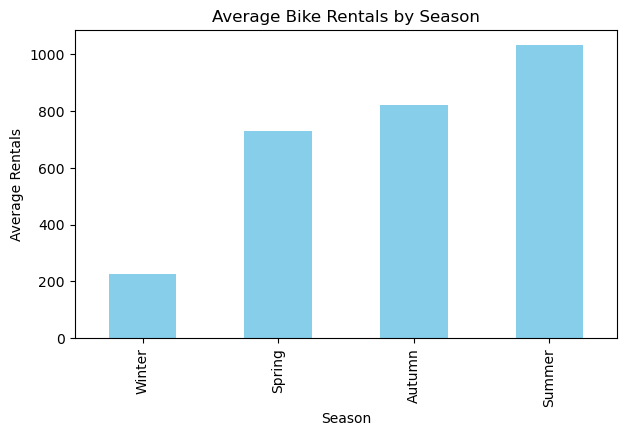

In [7]:
avg_by_season = df.groupby("Seasons")["Rented Bike Count"].mean().sort_values()

avg_by_season.plot(kind="bar", figsize=(7,4), color="skyblue")
plt.title("Average Bike Rentals by Season")
plt.ylabel("Average Rentals")
plt.xlabel("Season")
plt.show()


*To check Holidays vs Non-Holidays to see if demand is higher or lower when people have the day off.*

From running the code you can see: 

- People tend to use these bikes spcifcally during non-hoidays maybe due to mostly working days the city would be bustling.

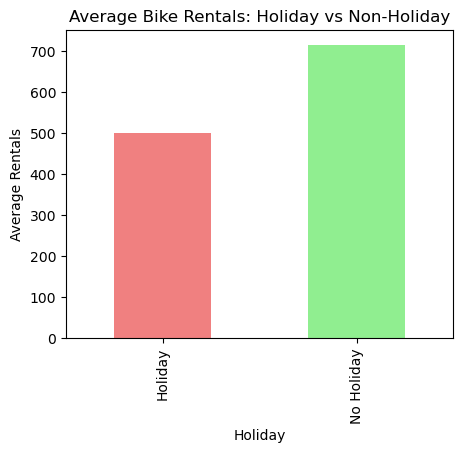

In [8]:
avg_by_holiday = df.groupby("Holiday")["Rented Bike Count"].mean()

avg_by_holiday.plot(kind="bar", figsize=(5,4), color=["lightcoral", "lightgreen"])
plt.title("Average Bike Rentals: Holiday vs Non-Holiday")
plt.ylabel("Average Rentals")
plt.xlabel("Holiday")
plt.show()


# Splitting the data

Train-Test Split since this is a time series dataset, we split the data in a way that would respect the chronologcical 

- Convert and formating the time "%d/%m/%Y" ensuring that every data in the row has the correct time sequnce. 
- Spliting dataset into 80% train dataset and 20% test dataset.

This method ensures there wouldnt be any data leakage of anysort and keep the consistence. 

In [9]:
# sort by date  also it is time based 
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df = df.sort_values("Date")

# 80% train, 20% test split 
split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index].copy()
test_df  = df.iloc[split_index:].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (7008, 14)
Test shape: (1752, 14)


# Feautre Engineering 

*We will first extract the features from Date, Month and DayOfWeek*

where 0=Monday till Sunday=6. Also keeping the weather features. 
At the same encoding the categorical columns:

- Seasons= Winter, Spring, Summer, Autumn 
- Holiday= Yes/No
- Functioning Day= Yes/No

In [10]:
# Add new time-based features
for d in [train_df, test_df]:
    d['Month'] = d['Date'].dt.month
    d['DayOfWeek'] = d['Date'].dt.dayofweek  

# Target
TARGET = "Rented Bike Count"

# Feature columns
numeric_cols = [
    "Hour","Month","DayOfWeek",
    "Temperature(°C)","Humidity(%)","Wind speed (m/s)",
    "Visibility (10m)","Dew point temperature(°C)",
    "Solar Radiation (MJ/m2)","Rainfall(mm)","Snowfall (cm)"
]

cat_cols = ["Seasons","Holiday","Functioning Day"]

features = numeric_cols + cat_cols

X_train = train_df[features]
y_train = train_df[TARGET]

X_test = test_df[features]
y_test = test_df[TARGET]


# Data Preprocessing 
- Over here all the catagorical column are one-hot encoded and numeric features are passed also keeping the numerical columns unchanged.

In [11]:

# Preprocessing: one-hot encode categoricals, pass numerics as-is
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  
)


# Machine Learning piplines

# Linear Regression 

In [12]:


linreg_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

# Fit on training data
linreg_pipe.fit(X_train, y_train)

# Predict on test data
y_pred_linreg = linreg_pipe.predict(X_test)

# Evaluation metrics
rmse = mean_squared_error(y_test, y_pred_linreg, squared=False)
mae = mean_absolute_error(y_test, y_pred_linreg)
r2 = r2_score(y_test, y_pred_linreg)

print("Linear Regression -->")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Linear Regression -->
RMSE: 409.07207793583916
MAE: 310.8768785416458
R²: 0.5551557864305441


# Decision Tree Regressor 


In [13]:


tree_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', DecisionTreeRegressor(random_state=42))
])

# Fit on training
tree_pipe.fit(X_train, y_train)

# Predict on test
y_pred_tree = tree_pipe.predict(X_test)

# Metrics
rmse = mean_squared_error(y_test, y_pred_tree, squared=False)
mae = mean_absolute_error(y_test, y_pred_tree)
r2 = r2_score(y_test, y_pred_tree)

print("Decision Tree -->")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Decision Tree -->
RMSE: 369.40672230485774
MAE: 249.73972602739727
R²: 0.6372412801583502


# Random Forest 

In [14]:

# Build pipeline
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit on training
rf_pipe.fit(X_train, y_train)

# Predict on test
y_pred_rf = rf_pipe.predict(X_test)

# Metrics
rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("Random Forest -->")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Random Forest -->
RMSE: 320.74770317693486
MAE: 223.3824229452055
R²: 0.7265138217579634


# Gradient Boosting (ENSEMBLE)

In [18]:

gb_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', GradientBoostingRegressor(random_state=42))
])

gb_pipe.fit(X_train, y_train)
y_pred_gb = gb_pipe.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_gb, squared=False)
mae = mean_absolute_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)

print("Gradient Boosting -->")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Gradient Boosting -->
RMSE: 368.15466368268585
MAE: 260.6556446088715
R²: 0.6396961649031616


# K-Nearest Neighbors

In [19]:

knn_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', KNeighborsRegressor(n_neighbors=5))
])

knn_pipe.fit(X_train, y_train)
y_pred_knn = knn_pipe.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_knn, squared=False)
mae = mean_absolute_error(y_test, y_pred_knn)
r2 = r2_score(y_test, y_pred_knn)

print("KNN -->")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


KNN -->
RMSE: 579.0651056644439
MAE: 409.8448630136986
R²: 0.10861963674291142


# SVR

In [23]:

svr_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', SVR(kernel='rbf'))
])

svr_pipe.fit(X_train, y_train)
y_pred_svr = svr_pipe.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_svr, squared=False)
mae = mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

print("SVR Performance -->")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


SVR Performance -->
RMSE: 663.456629818226
MAE: 521.0316152323636
R²: -0.17012793782515212


*To compare the scores of each model that are "rmse", "mae" and "r2" along with the final model name as the winner*

In [24]:

results = []

def evaluate_model(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

#----------------------------------------------------------------
#Models we ran the train dataset on
evaluate_model("Linear Regression", y_test, y_pred_linreg)
evaluate_model("Decision Tree", y_test, y_pred_tree)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("Gradient Boosting", y_test, y_pred_gb)
evaluate_model("KNN", y_test, y_pred_knn)
evaluate_model("SVR", y_test, y_pred_svr)
#----------------------------------------------------------------


results_df = pd.DataFrame(results)

# Sorting by RMSE which is better if its is lower as its better for precise predications
results_df = results_df.sort_values(by="RMSE")
print(results_df)

#
winner = results_df.iloc[0]
print("Best Model is --> (^-^) ", winner["Model"])
print("   RMSE:", winner["RMSE"])
print("   MAE:", winner["MAE"])
print("   R²:", winner["R²"])


               Model        RMSE         MAE        R²
2      Random Forest  320.747703  223.382423  0.726514
3  Gradient Boosting  368.154664  260.655645  0.639696
1      Decision Tree  369.406722  249.739726  0.637241
0  Linear Regression  409.072078  310.876879  0.555156
4                KNN  579.065106  409.844863  0.108620
5                SVR  663.456630  521.031615 -0.170128
Best Model is --> (^-^)  Random Forest
   RMSE: 320.74770317693486
   MAE: 223.3824229452055
   R²: 0.7265138217579634


# Machine Learning evalution
After running the maching learning models with the train dataset we were able to find out Random Forest is the best suited. This might take quite a long time, well about 10-12 mins. 

- For reference the score when the code was runned previously --> Best CV score (RMSE): 332.3125535771503

In [25]:

# Define parameter grid for tuning
param_grid = {
    'model__n_estimators': [100, 200, 400],       # number of trees
    'model__max_depth': [None, 10, 20],           # depth of trees
    'model__min_samples_split': [2, 5, 10],       # split criteria
    'model__min_samples_leaf': [1, 2, 4]          # leaf size
}

# Rebuild pipeline with RF
rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# GridSearch with 3-fold cross-validation
grid_search = GridSearchCV(
    rf_pipe,
    param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

# Fit only on training data (not test!)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score (RMSE):", -grid_search.best_score_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  14.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  14.3s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=100; total time=  16.0s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=  29.1s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=100; total time=  13.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=  30.5s
[CV] END model__max_depth=None, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=  31.2s
[CV] END model__max_d

# Evaluate the tuned model on the TEST DATA

In [26]:
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_best, squared=False)
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

print("Final Model on Test Data:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)


Final Model on Test Data:
RMSE: 323.1038913017398
MAE: 223.89500899285426
R²: 0.7224810465883365


### Upon the data analysis, another question that striked was what are the most important features.

- "OneHotEncoder expands categories into multiple columns"



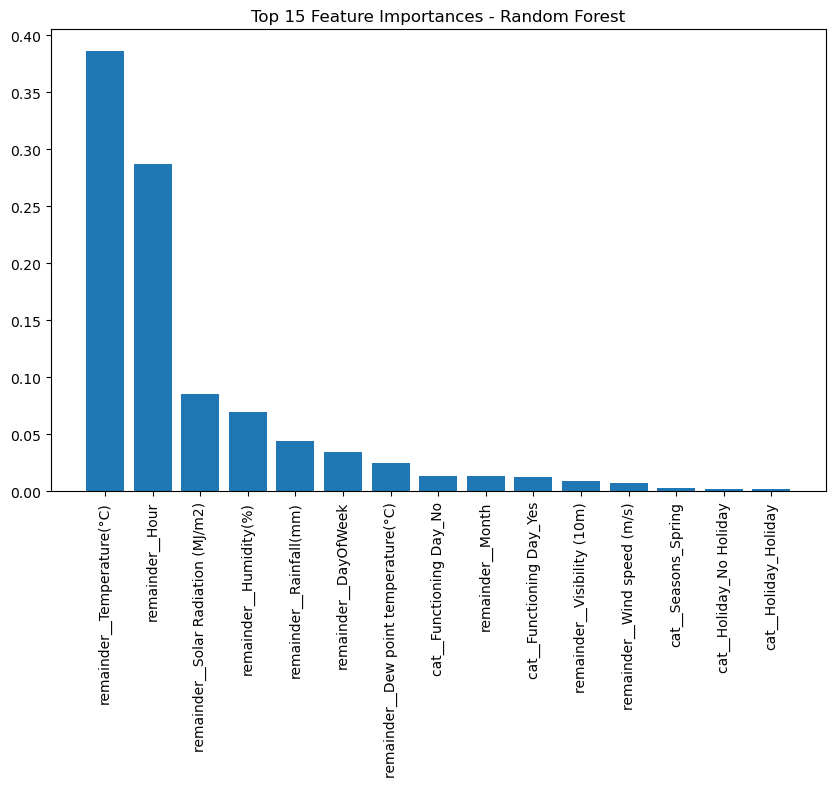

In [27]:

# Get feature names after preprocessing

feature_names = grid_search.best_estimator_.named_steps['preprocess'].get_feature_names_out()


importances = grid_search.best_estimator_.named_steps['model'].feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot top 15 features
plt.figure(figsize=(10,6))
plt.bar(range(15), importances[indices][:15], align="center")
plt.xticks(range(15), feature_names[indices][:15], rotation=90)
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()


### Resudal check to check where the modl struggles for example peaks, holidays or nights...*

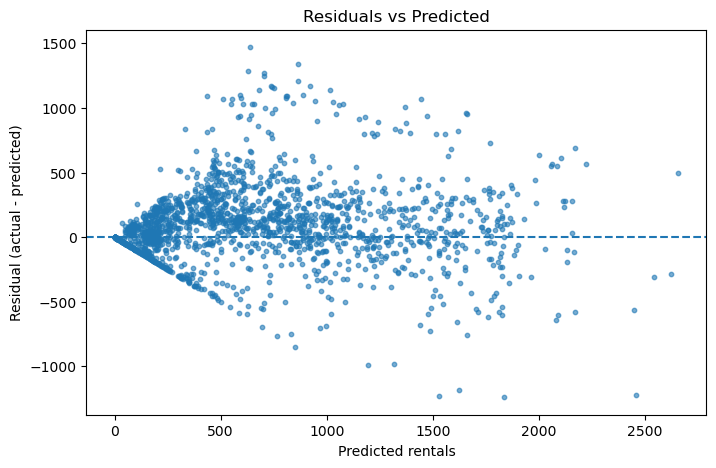

In [42]:


residuals = y_test - y_pred_best

plt.figure(figsize=(8,5))
plt.scatter(y_pred_best, residuals, s=10, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted rentals")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residuals vs Predicted")
plt.show()


### Error by hour to show when the forecasting is hardest. 

- Bike demand is very time-dependant. Upon running the code the model got "Error" exaclty right showing that there is a high demand in need for bikes of errors around 8 am and 6-7 pm.

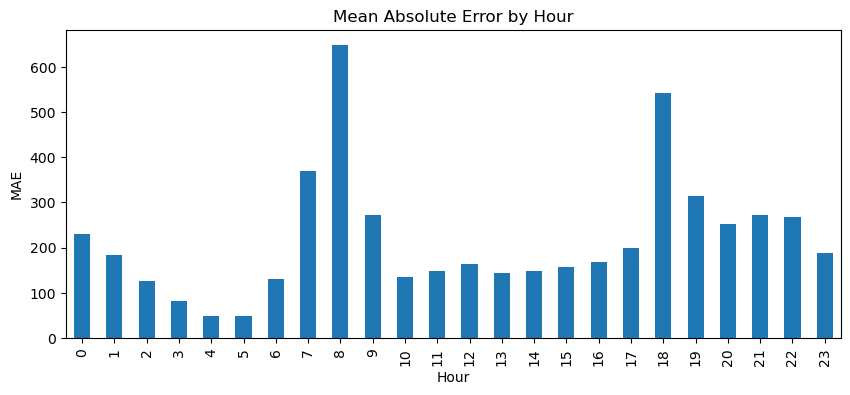

In [43]:
test_with_preds = test_df.copy()
test_with_preds['pred'] = y_pred_best
test_with_preds['abs_err'] = (test_with_preds['Rented Bike Count'] - test_with_preds['pred']).abs()

err_by_hour = test_with_preds.groupby('Hour')['abs_err'].mean()
err_by_hour.plot(kind='bar', figsize=(10,4))
plt.title("Mean Absolute Error by Hour")
plt.ylabel("MAE")
plt.show()


### Predicted vs Actual Rentals

Upon running the code:
- **Blue line** indicates the **actual rentals** "WHAT ACTUALLY REALLY HAPPENED" 
- **Orange line** shows the **predicted rentals** that our machine learning model was able to forcast.

And from reading the graph you can see how close the predictions track the real demand trend.
Even the flat or steady parts are predicted quite well which shows the overlap.  

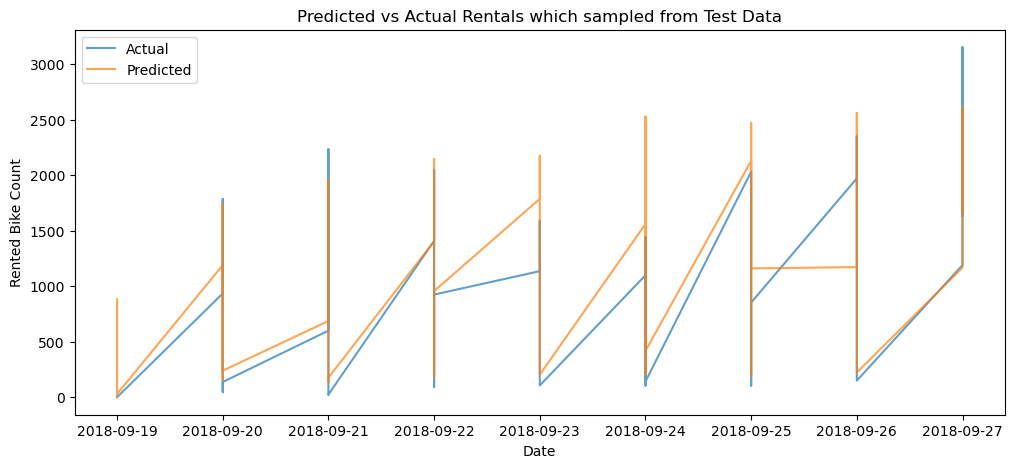

In [28]:
plt.figure(figsize=(12,5))
plt.plot(test_df['Date'][:200], y_test[:200], label="Actual", alpha=0.7)
plt.plot(test_df['Date'][:200], y_pred_best[:200], label="Predicted", alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual Rentals which sampled from Test Data")
plt.xlabel("Date")
plt.ylabel("Rented Bike Count")
plt.show()


# Scenario Simulation

To demonstrate practical application, we simulate demand factoring in real world detailed scenarios forexample 
- **cold, rainy Winter morning at 8 AM** 
- **A warm and sunny summer evening during rush hour**
- **A holiday afternoon in autumn with heavy rain**

The model predicts around **X rentals** under these conditions.  
Such “what-if” forecasting helps the operating comapny decide how many bikes to pre-position at various stations, especially during **challenging weather and peak times**.


In [ ]:
sample1 = pd.DataFrame({
    "Hour": [8],
    "Month": [12],
    "DayOfWeek": [0],
    "Temperature(°C)": [-2],
    "Humidity(%)": [80],
    "Wind speed (m/s)": [2],
    "Visibility (10m)": [1200],
    "Dew point temperature(°C)": [-5],
    "Solar Radiation (MJ/m2)": [0],
    "Rainfall(mm)": [2],
    "Snowfall (cm)": [1],
    "Seasons": ["Winter"],
    "Holiday": ["No Holiday"],
    "Functioning Day": ["Yes"]
})

prediction = best_rf.predict(sample1)
print(f"Predicted rentals for cold, rainy Winter morning at 8AM: {int(prediction[0])}")


Predicted rentals for cold, rainy Winter morning at 8AM: 306


In [30]:
sample2 = pd.DataFrame({
    "Hour": [18],  # evening rush
    "Month": [7],  # July
    "DayOfWeek": [2],  # Wednesday
    "Temperature(°C)": [28],
    "Humidity(%)": [55],
    "Wind speed (m/s)": [1.5],
    "Visibility (10m)": [2000],
    "Dew point temperature(°C)": [19],
    "Solar Radiation (MJ/m2)": [3],
    "Rainfall(mm)": [0],
    "Snowfall (cm)": [0],
    "Seasons": ["Summer"],
    "Holiday": ["No Holiday"],
    "Functioning Day": ["Yes"]
})

prediction2 = best_rf.predict(sample2)
print(f"Predicted rentals for warm, sunny Summer evening at 6PM: {int(prediction2[0])}")


Predicted rentals for warm, sunny Summer evening at 6PM: 2933


In [31]:
sample3 = pd.DataFrame({
    "Hour": [14],  # early afternoon
    "Month": [10],  # October
    "DayOfWeek": [6],  # Sunday
    "Temperature(°C)": [16],
    "Humidity(%)": [90],
    "Wind speed (m/s)": [3],
    "Visibility (10m)": [600],
    "Dew point temperature(°C)": [14],
    "Solar Radiation (MJ/m2)": [0.5],
    "Rainfall(mm)": [15],  # heavy rain
    "Snowfall (cm)": [0],
    "Seasons": ["Autumn"],
    "Holiday": ["Holiday"],
    "Functioning Day": ["Yes"]
})

prediction3 = best_rf.predict(sample3)
print(f"Predicted rentals for rainy Autumn holiday afternoon at 2PM: {int(prediction3[0])}")


Predicted rentals for rainy Autumn holiday afternoon at 2PM: 663
